<a href="https://colab.research.google.com/github/aachen6/deepTC/blob/master/colab/deepTC_classification_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepTC - Resnet

The overall objective of *deepTC* can be found on [deepTC github page](https://github.com/aachen6/deepTC/) for new readers. In the [previous notebook](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_cnn5_classification.ipynb), we demonstrated the implementation and training of a five-layer convolution network for the TC intensity classification from the satellite images and achieved a test accuray of 95.7%. It is possible to design a different convolution architecture, e.g. deep layers and/or with longer channels, to imrpove the model accuracy. However, we turn into a different concept in this notebook for TC intensity classification, i.e. residual net. The reason is that deep simple stacking convolution layers may be subject to the notorious vanishing gradient problem. The purpose is to demonstrate i) how a different architecture can be easily implemented using the system we developed so far; ii) the performance of the residual net with the same depth for the same problem.

1. Data Preprocess
 - 1.1 [Satellite images and tracks of TCs](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_images_tracks_sync.ipynb)
 - 1.2 [Statistics of satellite images and tracks](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_images_tracks_stats.ipynb)

2. Model for TC image
 - 2.1 [Post-binding architecture of TC image](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_net_image.ipynb)
 - 2.2 [CNN model for intensity classification](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_classification_cnn5.ipynb)
 - **2.3 [Resnet model for intensity classification](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_classification_resnet.ipynb)**
 - 2.4 [Resnet model for TC intensity estimation](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_intensity_resnet.ipynb)

3. Generversial Model for TC image
 - 3.1 [DCGAN model for deepTC](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_dcgan.ipynb)

4. Model for TC Track
 - 4.1 [Post-binding architecture of TC Track](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_net_track.ipynb)
 - 4.2 [LSTM model for TC track prediction](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_track_lstm.ipynb)
 - 4.3 [LSTM-CNN model for TC track prediction](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_track_lstmcnn.ipynb)


As usual, let's start with importing the necessary python modules,  reusing our previous notebooks by installing *import-ipynb*, and mounting the Google Drive to access the data we processed earlier. For  new readers, you can find a copy of those datasets in [deepTC github page](https://github.com/aachen6/deepTC/).

In [0]:
!pip install import-ipynb

In [0]:
import os 
import yaml
import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

work_dir = r'/content/drive/My Drive/Colab Notebooks/deepTC'
p_data  = work_dir + os.sep + 'data/AL'
p_image = work_dir + os.sep + 'image/AL'
p_model = work_dir + os.sep + 'model/tc_classification/resnet'

# load class defined in other ipynb
import import_ipynb
model_ipynb = work_dir + os.sep + 'deepTC_net_image.ipynb'
with open(model_ipynb, 'rb') as fp:
    with open('deepTC_net_lib.ipynb','wb') as fout:
       fout.write(fp.read())
  
import deepTC_net_lib
from deepTC_net_lib import YML2Model, ImageDataSet, ImageTrainer, ImageInference


##ResNet

For simple sequentially stacking layers of deep neutral network,  repeated multiplication through the back-propagation may make the gradient infinitively small at earlier layers, causing the notorious vanishing gradient problem. As the network depth increases, the performance is not monotonically enhancing and may get saturated or even degrading rapidly. ResNet was firstly introduced in [this paper](https://arxiv.org/pdf/1512.03385.pdf) in 2015 by Microsoft research team to overcome this problem. In a nutshell, deep residual network is an architecture that fits a residual mapping rather than the underlying mapping by carrying the input to the output within a building block (residual block), and recast the underlying mapping as the summation of the input and the output from the original mapping, as shown in Figure below.

![residual block](https://cdn-images-1.medium.com/max/750/1*ByrVJspW-TefwlH7OLxNkg.png) *Image Credit: [https://arxiv.org/pdf/1512.03385.pdf](https://arxiv.org/pdf/1512.03385.pdf)*

###Network Architecture
As compared with the *CNN5 net* developed in the [previous notebook](https://), the only thing that needs be updated to implement the *Resnet* is to revise the network architecture in the configuration file. The first layer maps one channel greyscale images into 32 channels with a 3 x 3 filter and reduces the feature map size by a factor of four using *maxpool2d* function with stride of 2. It's followed by two residual blocks, and each has one convolution layer that doubles the channel size and one with constant channel size. *ReLU* is applied at xxx. The *avgpool2d* with reduction of 16 is applied following the last convolution layer. The last two layer is the same as that in the *CNN5 net*, which transforms the feature space into a vector of 7 corresponding to the number of classes. Please note other than the different network architecture, this is not an apple to apple comparison as pooling is not used to reduce the feature size in the resnet block as suggested in xxx. The overall number of parameter is higher than the *CNN5 net*.  

<img src='https://raw.githubusercontent.com/aachen6/deepTC/master/model/tc_classification/resnet/resnet.png' width='800'/>

The same dataset used for *CNN5 net* is used here for consistency, which has a separation ration of 72:18:10 among training, validation, and testing set. Similarly, *Cross-Entropy* loss with *Adam* optimizer are used with the default learning rate &eta;=0.001 and momentum parameters (&beta;<sub>1</sub>=0.9, &beta;<sub>2</sub>=0.999). Similary, we trained the model for 15 epochs with a batch size of 64. The loss and accuracy of each batch and epoch (running average) are generated and updated in the plot below during the training and validation process. The *Resnet* converges even faster reaching a validation accuracy of 95% after 3 epochs, and achieves a final validation accuary of 98.9% after 15 epochs.

###Training and Validation

In [0]:
import torch
from torchvision.transforms import transforms

torch.cuda.empty_cache()

# load configuration file
f_config = p_model + os.sep + 'config_resnet.yaml'
with open(f_config, 'r') as fp: config = yaml.load(fp)

# contruct the model
storm_resnet = YML2Model(config, 'resnet')

# update path for config
config_params = config['params']
config_params['f_image_zip'] = p_image + os.sep + config_params['f_image_zip']
config_params['f_storm_msg'] = p_data  + os.sep + config_params['f_storm_msg']
config_params['f_state_yml'] = p_model + os.sep + config_params['f_state_yml']
config_params['f_model_pth'] = p_model + os.sep + config_params['f_model_pth']
config_params['f_test_yml']  = p_model + os.sep + config_params['f_test_yml']

# splitted data to be used in other model as well for comparison
config_params['f_data_yml']  = work_dir + os.sep + 'model/tc_classification' + os.sep + config_params['f_data_yml']

# normalization is based on ramdon 1000 samples for this test
image_transforms = transforms.Compose([
    transforms.Grayscale(1),
    transforms.ToTensor(),
    transforms.Normalize((0.456,), (0.222,))])

# dataset
storm_data = ImageDataSet(config_params, image_transforms, hotstart=True)
data_split = storm_data.load_data()

# model
storm_train = ImageTrainer(config_params, storm_resnet, hotstart=False)

# train & valid
storm_train.train_loop(data_split)

# test
test_results = storm_train.test_loop(data_split)


------------------------------------
summary of dataset
------------------------------------
               train     valid      test
percent         0.72      0.18      0.10
size           34944      8742      4857
batch            546       136        75
------------------------------------
summary of GPU
------------------------------------
Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
------------------------------------
training
------------------------------------


------------------------------------
summary of epoch: 0
------------------------------------
                loss  accurary
train          1.042    61.238
valid          0.664    76.443
 


------------------------------------
summary of epoch: 1
------------------------------------
                loss  accurary
train          0.400    86.350
valid          0.241    92.441
 


------------------------------------
summary of epoch: 2
------------------------------------
                loss  accurary
train          0.171    94.797
valid          0.132    95.875
 


------------------------------------
summary of epoch: 3
------------------------------------
                loss  accurary
train          0.101    97.027
valid          0.094    97.395
 


------------------------------------
summary of epoch: 4
------------------------------------
                loss  accurary
train          0.079    97.516
valid          0.070    98.095
 


------------------------------------
summary of epoch: 5
------------------------------------
                loss  accurary
train          0.064    97.937
valid          0.057    98.430
 


------------------------------------
summary of epoch: 6
------------------------------------
                loss  accurary
train          0.046    98.589
valid          0.048    98.544
 


------------------------------------
summary of epoch: 7
------------------------------------
                loss  accurary
train          0.042    98.629
valid          0.047    98.677
 


------------------------------------
summary of epoch: 8
------------------------------------
                loss  accurary
train          0.038    98.792
valid          0.048    98.540
 


------------------------------------
summary of epoch: 9
------------------------------------
                loss  accurary
train          0.032    98.998
valid          0.054    98.369
 


------------------------------------
summary of epoch: 10
------------------------------------
                loss  accurary
train          0.032    98.987
valid          0.041    98.814
 


------------------------------------
summary of epoch: 11
------------------------------------
                loss  accurary
train          0.030    99.056
valid          0.028    99.088
 


------------------------------------
summary of epoch: 12
------------------------------------
                loss  accurary
train          0.026    99.127
valid          0.030    98.985
 


------------------------------------
summary of epoch: 13
------------------------------------
                loss  accurary
train          0.027    99.170
valid          0.035    98.905
 


------------------------------------
summary of epoch: 14
------------------------------------
                loss  accurary
train          0.016    99.548
valid          0.041    98.909
 
------------------------------------
summary of test
------------------------------------
               total  accuracy
test            4857    96.000


###Test Performance

On the test of the optimized model, the overall test accuracy is 97.0% with a 1.3% improvement from the *CNN5 net*. The confusion matrix below also shows that the model perform well for classes with much less samples, indicating the model is not sensitive to such imbalance in the sample classes. It performs less well for the  prediction of HU5 that has the least number of samples for this run.

------------------------------------
summary of test
------------------------------------
               total  accuracy
test            4857    96.973


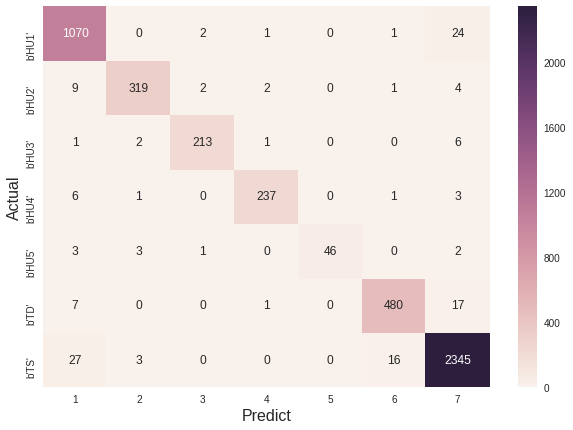

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# CONSTANT
f_data_yml = config_params['f_data_yml']
with open(f_data_yml, 'rb') as fp: data = yaml.load(fp)
    
one_hot_key   = data['one_hot_key']
one_hot_rev   = data['one_hot_rev']
train_indices = data['indices']['train']
valid_indices = data['indices']['valid']
test_indices  = data['indices']['test']

f_test = config_params['f_test_yml']
with open(f_test, 'r') as fp: test_results = yaml.load(fp)
test_idxs = test_results['idxs']
#test_idxs = test_idxs.detach().numpy()
test_labels = test_results['labels']
test_predicts = test_results['predicts']
   
# check test data, for debug purpose to make sure test dataset is correct
# f_img_msg = p_data + os.sep + 'al_ir_track_filtered.msg'
# pd_storm = pd.read_msgpack(f_img_msg) 
# print(len(test_labels))
# print(len(pd_storm.iloc[test_indices].index))
# print(pd_storm.iloc[test_indices].groupby(b'cat').count())
# print(np.unique(test_labels, return_counts=True))

# test summary
n_correct = np.equal(test_predicts, test_labels).sum().item()
accuracy = n_correct / len(test_labels) * 100.
divider = '-' * 36
print(divider)
print('summary of test')
print(divider)
print('{:<10s}{:>10s}{:>10s}'.format('', 'total', 'accuracy'))
print('{:<10s}{:>10d}{:>10.3f}'.format('test', len(test_labels), accuracy))   
        

# confusion matrix
cfx = confusion_matrix(test_labels, test_predicts)
df_cfx = pd.DataFrame(cfx, index = [one_hot_rev[i] for i in range(7)], 
                           columns = [str(i+1) for i in range(7)])

fig, ax = plt.subplots(figsize = (10,7))
sns.heatmap(df_cfx, annot=True, annot_kws={'size': 12}, fmt='d', ax=ax)
ax.set_xlabel('Predict',fontsize=16)
ax.set_ylabel('Actual',fontsize=16)

# true_to_false
true_to_false = {} # miss-classified images
for i in range(7): true_to_false[one_hot_rev[i]] = []
for i, (x, y) in enumerate(zip(test_labels, test_predicts)):
    if x==y: continue
    true_cat = one_hot_rev[x]
    false_cat = one_hot_rev[y]
    true_to_false[true_cat].append([test_idxs[i], false_cat])
    

##Inference

This section shows how a trained model can be put into operation through inference. As an example, the model predicts a satellite IR image from NRL to be category 4 hurricane, which matches that from the best track. This is a dummy example as most likely the image is in the training dataset. Since no data augmentation is used during the train, the model does not generalize well to a different image set, i.e. storms centered differently etc. Without data augmentation, the model is currently limited to IR images similar to that from NRL. 

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms

f_config = p_model + os.sep + 'config_resnet.yaml'
with open(f_config, 'r') as fp: config = yaml.load(fp)

config_params = config['params']
config_params['f_image_zip'] = p_image + os.sep + config_params['f_image_zip']
config_params['f_storm_msg'] = p_data  + os.sep + config_params['f_storm_msg']
config_params['f_state_yml'] = p_model + os.sep + config_params['f_state_yml']
config_params['f_model_pth'] = p_model + os.sep + config_params['f_model_pth']
config_params['f_test_yml']  = p_model + os.sep + config_params['f_test_yml']
config_params['f_data_yml']  = work_dir + os.sep + 'model/tc_classification' +  \
                                          os.sep + config_params['f_data_yml']

f_data_yml = config_params['f_data_yml']
with open(f_data_yml, 'rb') as fp: data = yaml.load(fp)    
one_hot_key   = data['one_hot_key']
one_hot_rev   = data['one_hot_rev']

storm_infer = ImageInference(config, 'resnet')
      
image_transforms = transforms.Compose([
    transforms.Grayscale(1),
    transforms.ToTensor(),
    transforms.Normalize((0.456,), (0.222,))])

In [0]:
###@title Number fields
URL = 'https://www.nrlmry.navy.mil/tcdat/tc05/ATL/18L.RITA/ir/geo/1km_bw/20050923.0600.goes10.x.ir1km_bw.18LRITA.120kts-924mb-265N-907W.jpg' #@param {type:'string'}

import requests
from io import BytesIO
from PIL import Image

try: 
  response = requests.get(URL, stream=True)
  sample = Image.open(BytesIO(response.content))
  sample = sample.crop((64, 64, 960, 960))
  sample = sample.resize((256,256))
except:
  print ('Wrong URL:', URL)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


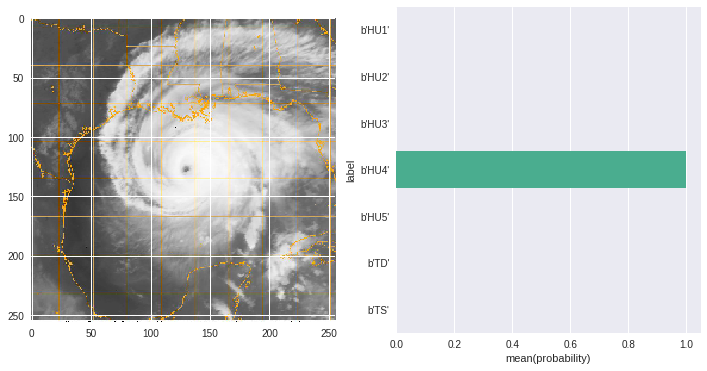

In [0]:
#row = pd_storm[pd_storm[b'key']=='AL200518RITA09220845'].iloc[0]
#cat = row[b'cat']
#image = row[b'image'].decode('utf-8')
#temp = image.split('.')[0].split('_')
#f_image = temp[0] + '_' + temp[1] + '.jpg'
#sample = Image.open(img_archv.open(f_image))     

img_tensor = image_transforms(sample)
img_tensor = img_tensor.unsqueeze(0)

predict = storm_infer.inference(img_tensor)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))  
ax1.imshow(sample)

data = []
for key, value in one_hot_rev.items():
    data.append([value, predict[0][key]])

df_predict = pd.DataFrame(data, columns=['label','probability'])
sns.barplot(x='probability', y='label', data=df_predict, ax=ax2)
